# Data Management

## Setup

In [1]:
# Import modules
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances


In [2]:
# Load data
df = pd.read_excel('/Users/julienmbarki/Documents/Doctorat/Publications/Article 2/Data/Code/data_requests/df_gaming.xlsx')

# Group by playlist name
groups = df.groupby('playlist_name')


## PCA dimensionnality reduction

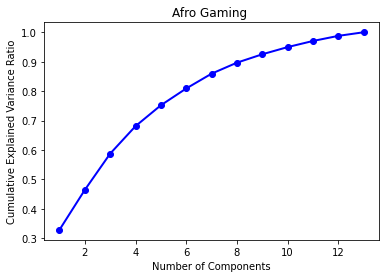

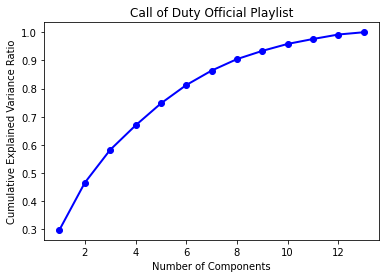

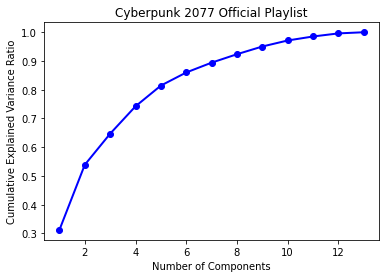

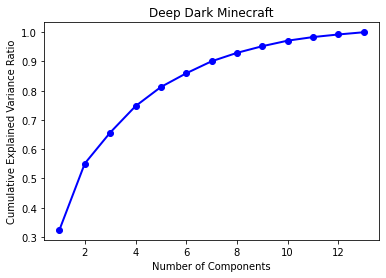

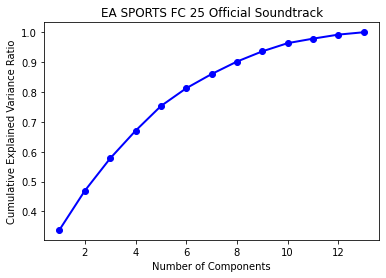

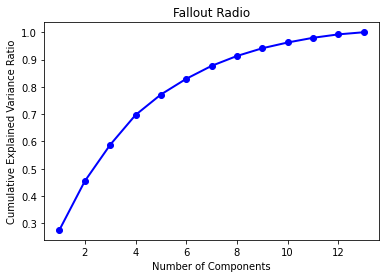

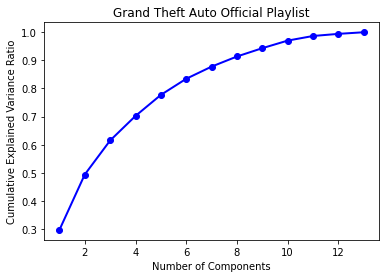

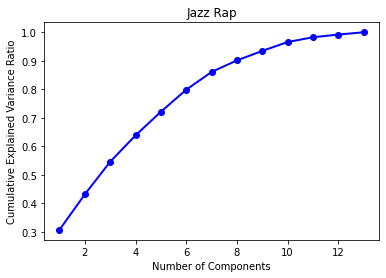

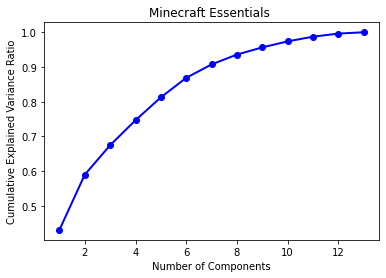

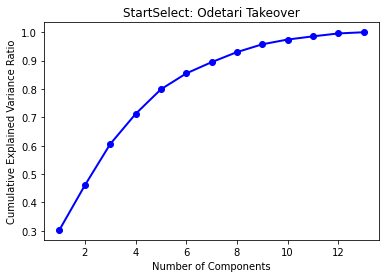

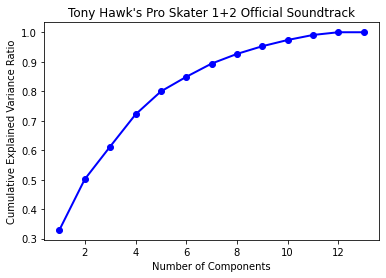

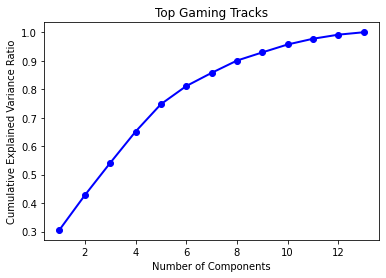

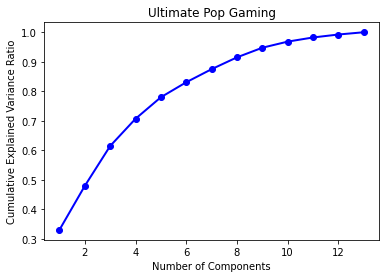

Most modal value of optimal components: 6


In [3]:
# Select the number of components
scaler = MinMaxScaler()

optimal_num_components = []

for group_name, group in groups:
    # Subset and scale
    subset = group.loc[:, "danceability":"time_signature"]
    scaled_columns = scaler.fit_transform(subset)

    # Apply PCA
    pca = PCA()
    pca.fit(scaled_columns)
    
    # Calculate cumulative explained variance
    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    optimal_components = next(i for i, var in enumerate(cumulative_variance) if var >= 0.8) + 1
    optimal_num_components.append(optimal_components)

    # Plot scree plot
    plt.plot(range(1, pca.n_components_ + 1), cumulative_variance, 'bo-', linewidth=2)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(group_name)
    plt.show()

# Calculate the most modal value
most_common_optimal = Counter(optimal_num_components).most_common(1)
most_modal_value = most_common_optimal[0][0]

print("Most modal value of optimal components:", most_modal_value)


In [4]:
# Apply PCA to reduce dimensionality
# Loop over each group and apply PCA with optimal number of components
scaler = MinMaxScaler()

reduced_data_dict = {}

for group_name, group in groups:
    # Subset data
    subset = group.loc[:, "danceability":"time_signature"]

    # Scale the specified columns
    scaled_columns = scaler.fit_transform(subset)

    # Apply PCA with the optimal number of components
    n_components = 6
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_columns)
    reduced_data_dict[group_name] = reduced_data


## Clustering

### Elbow method

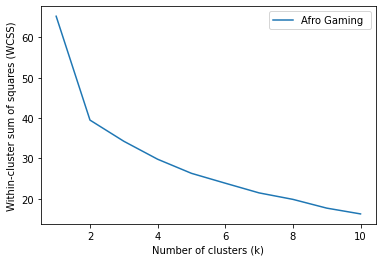

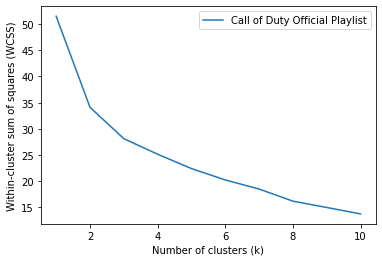

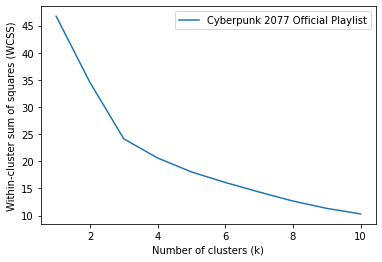

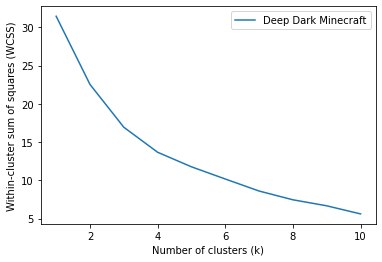

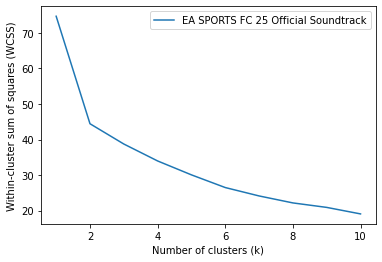

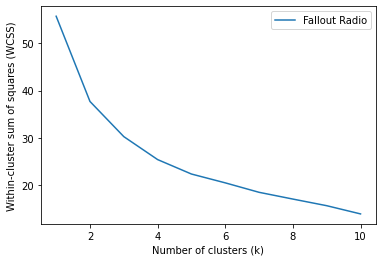

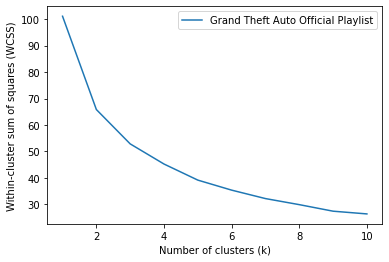

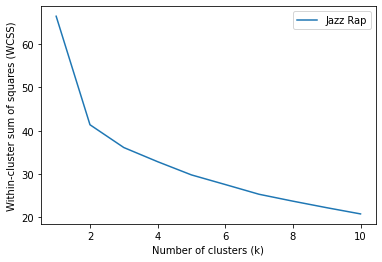

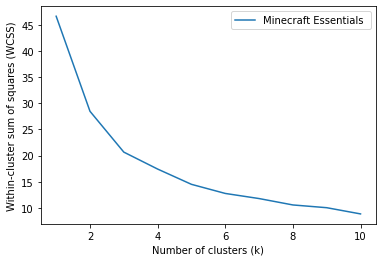

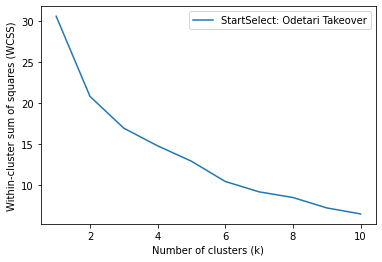

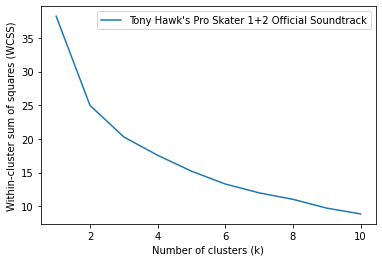

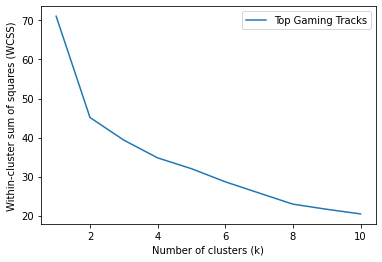

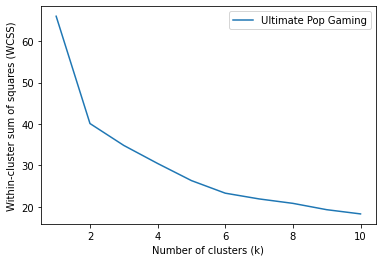

In [5]:
# Apply the elbow method to determine the optimal number of clusters
# Calculate the elbow
wcss = {}

for k in range(1, 11):
  for group_name, group in groups:
    reduced_data = reduced_data_dict[group_name]
    
    kmeans = KMeans(n_clusters=k, random_state=42).fit(reduced_data)
    
    if group_name not in wcss:
      wcss[group_name] = []

    wcss[group_name].append(kmeans.inertia_)

# Plot the elbow
for group_name, values in wcss.items():
  plt.plot(range(1, 11), values, label=group_name)
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('Within-cluster sum of squares (WCSS)')
  plt.legend()
  plt.show()


### Gap statistic method

In [6]:
# Set random seeds
random.seed(42)
np.random.seed(42)


In [7]:
# Define a function to compute the gap statistic
def compute_gap(data, k):
  # Compute the WCSS for the real data
  kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
  wcss = kmeans.inertia_

  # Compute the null reference distribution by shuffling the data and
  # re-assigning it to clusters
  n_samples, n_features = data.shape
  wcss_null = []

  for _ in range(20):
    data_shuffled = np.random.permutation(data)
    wcss_null.append(KMeans(n_clusters=k).fit(data_shuffled).inertia_)
  
  wcss_null = np.array(wcss_null)
  
  # Compute the gap statistic and gap*
  gap = np.mean(np.log(wcss_null)) - np.log(wcss)

  # Compute the standard deviation of the null reference distribution
  gap_std = np.std(np.log(wcss_null))

  return gap, gap_std


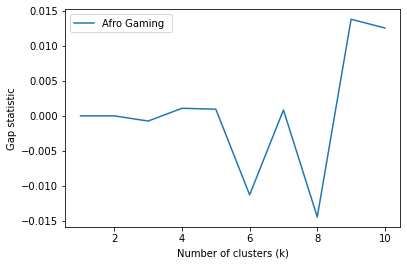

Group: Afro Gaming , Optimal k (gap): 2, Optimal k (gap*): 9


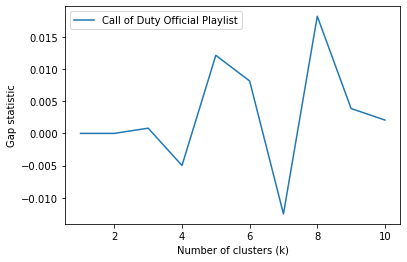

Group: Call of Duty Official Playlist, Optimal k (gap): 3, Optimal k (gap*): 8


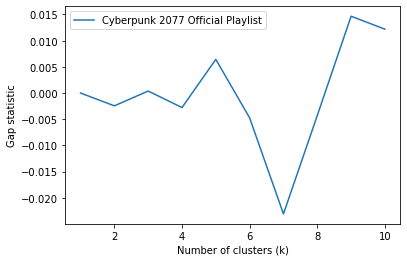

Group: Cyberpunk 2077 Official Playlist, Optimal k (gap): 3, Optimal k (gap*): 9


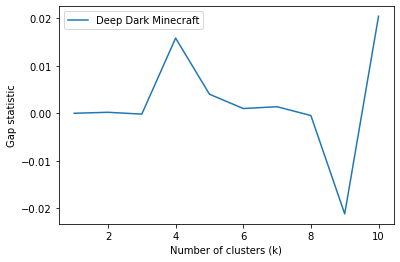

Group: Deep Dark Minecraft, Optimal k (gap): 2, Optimal k (gap*): 10


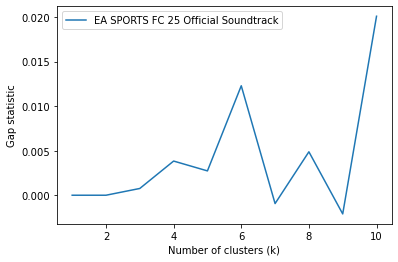

Group: EA SPORTS FC 25 Official Soundtrack, Optimal k (gap): 3, Optimal k (gap*): 10


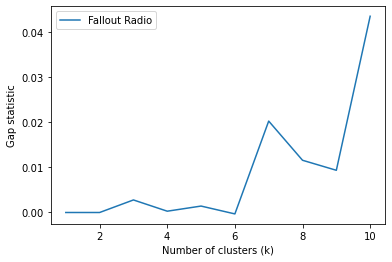

Group: Fallout Radio, Optimal k (gap): 3, Optimal k (gap*): 10


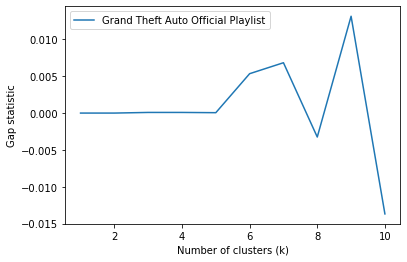

Group: Grand Theft Auto Official Playlist, Optimal k (gap): 3, Optimal k (gap*): 9


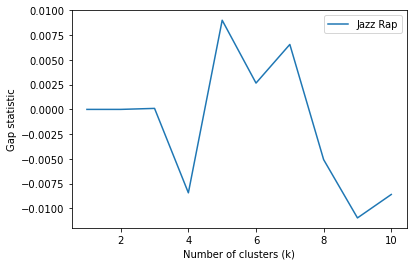

Group: Jazz Rap, Optimal k (gap): 3, Optimal k (gap*): 5


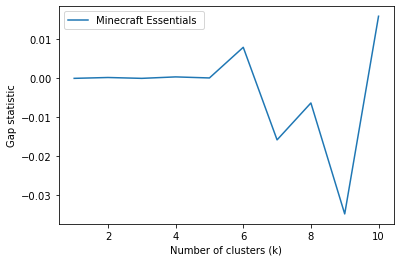

Group: Minecraft Essentials , Optimal k (gap): 2, Optimal k (gap*): 10


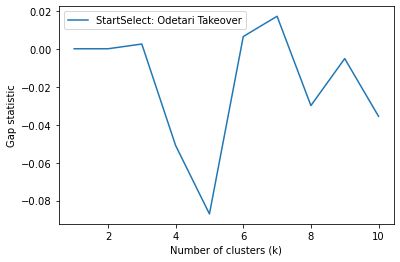

Group: StartSelect: Odetari Takeover, Optimal k (gap): 3, Optimal k (gap*): 7


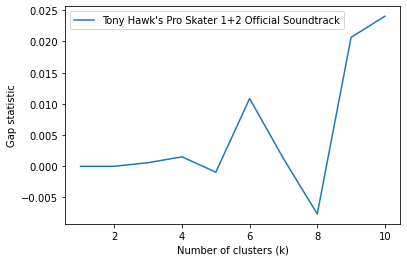

Group: Tony Hawk's Pro Skater 1+2 Official Soundtrack, Optimal k (gap): 3, Optimal k (gap*): 10


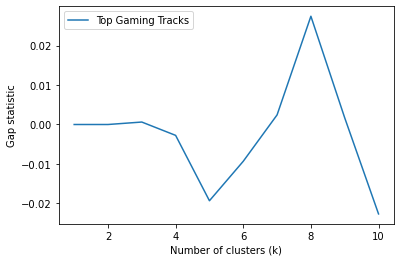

Group: Top Gaming Tracks, Optimal k (gap): 3, Optimal k (gap*): 8


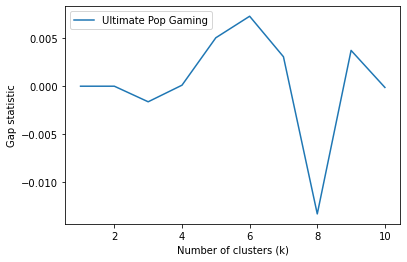

Group: Ultimate Pop Gaming, Optimal k (gap): 2, Optimal k (gap*): 6


In [8]:
# Calculate the optimal k
# Loop over each group and generate scree plot
optimal_num_k = {}
optimal_num_k_2 = {}

for group_name, group in groups:
    group_gaps = []
    group_errors = []

    for k in range(1, 11):
        reduced_data = reduced_data_dict[group_name]

        # Compute the gap statistic and standard deviation for the current value of k
        gap, gap_std = compute_gap(reduced_data, k)
        group_gaps.append(gap)
        group_errors.append(gap_std)

    # Find the optimal number of components based on the gap statistic criterion
    optimal_k = None
    for i in range(1, len(group_gaps) - 1):
        s_k = group_errors[i]
        threshold = s_k * np.sqrt(1 + 1 / 20)
        if group_gaps[i] >= group_gaps[i + 1] - threshold:
            optimal_k = i + 1
            break

    if optimal_k is None:
        optimal_k = np.argmax(group_gaps) + 1

    optimal_num_k[group_name] = optimal_k

    # Find the optimal number of components based on the gap* statistic criterion
    for i in range(1, len(group_gaps)):
        optimal_k_2 = np.argmax(group_gaps) + 1

    optimal_num_k_2[group_name] = optimal_k_2

    # Plot the gap statistics
    plt.plot(range(1, 11), group_gaps, label=group_name)

    # Set labels and display the plot
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Gap statistic')
    plt.legend()
    plt.show()

    print(f"Group: {group_name}, Optimal k (gap): {optimal_num_k[group_name]}, Optimal k (gap*): {optimal_num_k_2[group_name]}")


### Apply KMeans

Group Afro Gaming : [1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1
 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0]


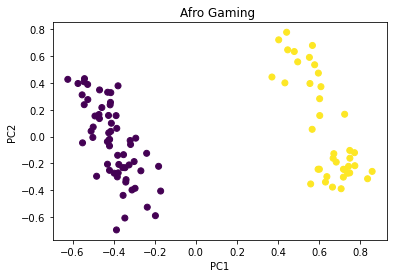

Group Call of Duty Official Playlist: [0 1 1 0 0 1 0 1 0 1 0 0 1 2 0 1 1 2 0 2 0 1 0 0 0 2 1 1 1 0 1 0 2 2 0 0 0
 1 2 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 2 1 1 0 0 0 0]


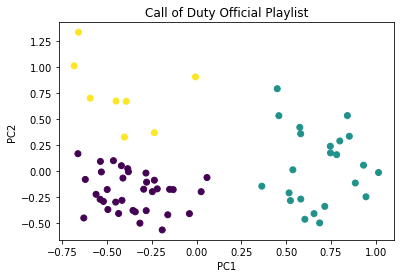

Group Cyberpunk 2077 Official Playlist: [1 2 2 1 1 2 2 1 1 2 0 2 0 1 1 1 2 2 2 1 0 0 2 2 2 0 2 0 0 2 2 2 0 1 0 1 2
 2 2 2 1 1 2 0 1 0 2 1 2 1]


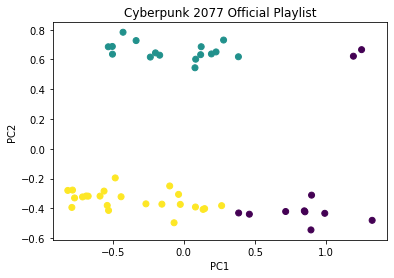

Group Deep Dark Minecraft: [0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0]


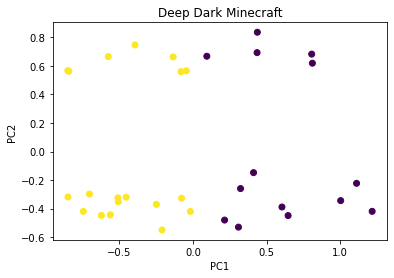

Group EA SPORTS FC 25 Official Soundtrack: [1 2 0 2 1 2 1 0 2 0 0 1 2 0 0 0 0 1 2 2 0 2 2 1 1 0 0 1 2 1 1 0 0 2 0 1 1
 0 1 1 2 1 2 1 1 0 1 0 1 1 1 1 2 0 1 1 1 0 2 0 0 1 1 0 0 0 2 1 1 0 1 1 1 0
 0 0 1 1 1 1 1 0 1 1 1 2 1 1 1 1 2 1 2 2 0 0 0 0 0 0 1 0 1 1 1 0 1 1 2 1 2
 1 0 1]


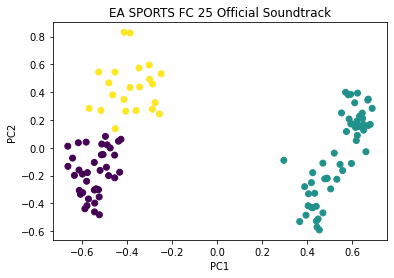

Group Fallout Radio: [2 2 0 2 2 2 2 2 2 0 0 2 2 1 2 2 1 2 1 0 2 2 2 2 2 2 1 2 2 1 1 2 0 1 0 0 2
 1 0 1 2 0 2 2 0 0 2 0 2 1 2 2 0 2 0 2 0 0 0 0 0 2 1 0 2 2 2 0 2 2 0 2 0 0
 2 2 0 2]


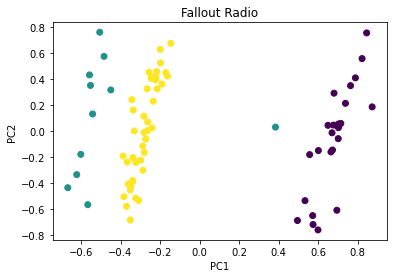

Group Grand Theft Auto Official Playlist: [2 2 0 2 0 0 2 2 0 2 0 2 1 2 2 0 2 1 2 1 1 2 2 0 2 2 0 1 1 2 0 0 2 0 2 0 0
 2 0 2 2 2 0 0 1 2 2 2 2 0 2 0 0 0 2 2 0 2 0 1 2 0 2 2 0 0 2 0 1 0 0 0 2 2
 2 1 0 2 2 0 1 0 0 0 2 2 2 0 1 2 0 0 0 2 2 1 2 2 0 2 1 0 0 2 0 0 2 2 2 2 2
 2 1 0 1 0 1 1 2 2 0 2 2 0 2 1 2 2 0 0 0 0 2 0 2 2 2 1 0 2 2 0 0 0]


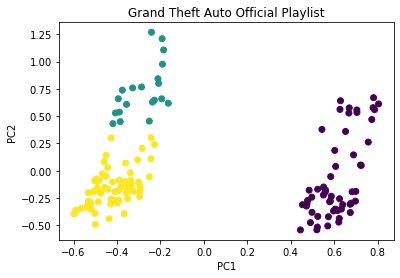

Group Jazz Rap: [0 0 2 2 0 1 0 0 2 2 1 1 0 2 2 2 1 2 2 0 2 1 0 0 2 0 0 2 1 0 2 2 1 0 2 1 0
 2 1 1 1 0 0 0 0 2 2 1 0 1 2 0 0 1 2 1 0 1 1 0 1 0 0 1 1 0 0 1 0 2 0 2 0 1
 1 0 1 2 0 0 1 0 1 0 1 0 2 1 0 0 0 2 1 1 1 2 0 1 2 1]


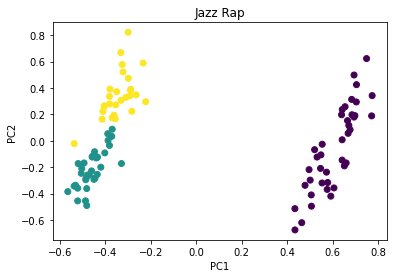

Group Minecraft Essentials : [0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 0 1 0 1]


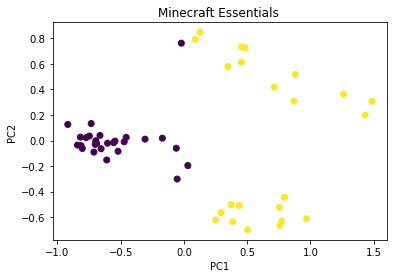

Group StartSelect: Odetari Takeover: [2 2 0 0 0 2 0 2 2 0 1 2 2 1 1 2 2 1 1 1 0 1 0 1 1 0 1 1 0 2 2 0 2]


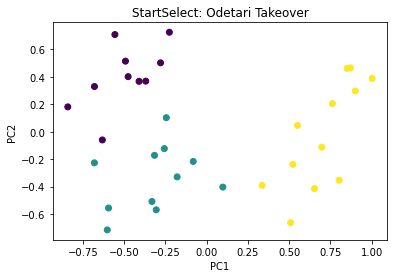

Group Tony Hawk's Pro Skater 1+2 Official Soundtrack: [2 2 2 2 2 2 2 0 1 1 2 1 1 2 2 1 1 2 1 2 0 2 0 2 0 0 0 2 2 2 2 1 1 0 2 1 2
 0 1 1 0 1 1 2 1 0 2 2 1 1 1 2 2]


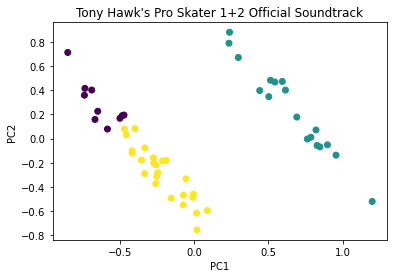

Group Top Gaming Tracks: [1 2 1 2 2 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0 2 0 1 0 0 2 1 2 1 2 1 2 1 0 2 1 2
 1 0 1 0 1 0 2 0 1 1 1 1 1 2 0 1 2 2 1 1 1 2 1 2 2 1 0 0 1 0 1 2 1 2 1 2 2
 0 2 1 0 0 2 1 1 2 1 0 1 2 0 0 1 1 2 1 0 0 0 1 1 0 0]


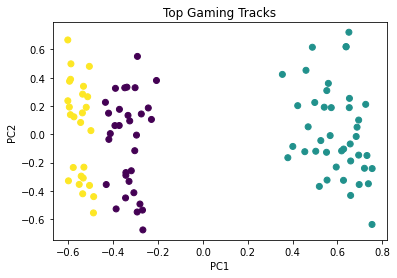

Group Ultimate Pop Gaming: [1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1
 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1]


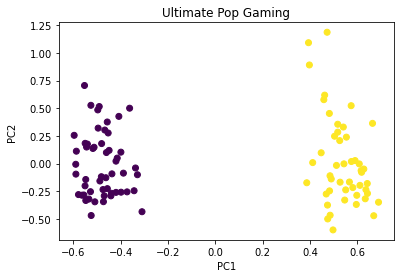

,playlist_name,playlist_followers,playlist_owner,track_name,track__popularity,track_release_date,artist_name,artist_popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_2
580,Afro Gaming,262,Spotify,Piece of My Heart (feat. Brent Faiyaz),76,2024-10-18,Wizkid,79,0.737,0.648,...,0.1380,0.25200,0.000007,0.105,0.746,93.200,259354,4,1,8
581,Afro Gaming,262,Spotify,Are you there?,69,2024-08-15,Ayo Maff,65,0.782,0.529,...,0.0592,0.50900,0.000001,0.413,0.440,112.014,156429,4,1,1
582,Afro Gaming,262,Spotify,Vision,57,2023-11-17,Qing Madi,60,0.633,0.374,...,0.1210,0.41200,0.000730,0.110,0.508,121.017,146000,5,0,5
583,Afro Gaming,262,Spotify,Love Me JeJe,72,2024-06-06,Tems,78,0.834,0.516,...,0.1380,0.15600,0.530000,0.109,0.531,103.955,178042,4,0,3
584,Afro Gaming,262,Spotify,Awolowo,71,2024-08-07,Fido,57,0.619,0.385,...,0.1180,0.12900,0.003690,0.179,0.294,106.312,135577,5,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,Ultimate Pop Gaming,407833,Spotify,Understand,67,2022-05-06,BoyWithUke,74,0.828,0.658,...,0.1400,0.81000,0.000001,0.277,0.917,103.051,171947,4,0,5
460,Ultimate Pop Gaming,407833,Spotify,Sharks,66,2022-06-24,Imagine Dragons,89,0.927,0.642,...,0.0657,0.00791,0.000036,0.279,0.901,123.969,190883,4,0,5
461,Ultimate Pop Gaming,407833,Spotify,LET ME IN,66,2024-09-27,CG5,66,0.675,0.902,...,0.0505,0.02450,0.002960,0.720,0.914,127.918,107817,4,1,1
462,Ultimate Pop Gaming,407833,Spotify,ANTIFRAGILE,66,2022-10-17,LE SSERAFIM,81,0.882,0.797,...,0.0819,0.08210,0.000000,0.113,0.824,105.025,184444,4,0,5


In [9]:
# Apply KMeans with optimal number of clusters
df = pd.DataFrame()

kmeans_dict = {}
kmeans_2_dict = {}
cluster_labels_dict = {}
cluster_labels_2_dict = {}

for group_name, group in groups:
    reduced_data = reduced_data_dict[group_name]

    k = optimal_num_k[group_name]
    k_2 = optimal_num_k_2[group_name]

    # Apply KMeans with optimal number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42).fit(reduced_data)
    kmeans_2 = KMeans(n_clusters=k_2, random_state=42).fit(reduced_data)
    
    kmeans_dict[group_name] = kmeans
    kmeans_2_dict[group_name] = kmeans_2

    cluster_labels_dict[group_name] = kmeans.labels_
    cluster_labels_2_dict[group_name] = kmeans_2.labels_

    print(f"Group {group_name}: {kmeans.labels_}")

    # Assign cluster labels to original group data
    group = group.assign(cluster=kmeans.labels_)
    group = group.assign(cluster_2=kmeans_2.labels_)

    # Append group to original dataframe
    df = pd.concat([df, group])
    
    # Plot clusters
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(group_name)
    plt.show()

display(df)


## Variables creation

### HH-Index

In [10]:
groups = df.groupby('playlist_name')


In [11]:
# Calculate the shares of each cluster
shares_perc = {}

for group_name, group in groups:
    shares = group['cluster'].value_counts(normalize=True)
    shares_perc[group_name] = shares * 100

# Calculate the HHI
hhi = {}
hhi_2 = {}

for group_name, group in groups:
  shares = group['cluster'].value_counts(normalize=True)
  hhi[group_name] = sum((shares*100)**2)

  shares_2 = group['cluster_2'].value_counts(normalize=True)
  hhi_2[group_name] = sum((shares_2*100)**2)

print(hhi)
print(hhi_2)

print("Minimum HHI: ", min(hhi.values()))
print("Mean HHI: ", np.mean(list(hhi.values())))
print("Median HHI: ", np.median(list(hhi.values())))
print("Maximum HHI: ", max(hhi.values()))
print("Standard deviation: ", np.std(list(hhi.values())))


{'Afro Gaming ': 5242.0, 'Call of Duty Official Playlist': 4173.553719008265, 'Cyberpunk 2077 Official Playlist': 3624.0, 'Deep Dark Minecraft': 5114.784205693297, 'EA SPORTS FC 25 Official Soundtrack': 3727.3007079101253, 'Fallout Radio': 4125.575279421433, 'Grand Theft Auto Official Playlist': 3935.185185185185, 'Jazz Rap': 3418.0, 'Minecraft Essentials ': 5032.0, 'StartSelect: Odetari Takeover': 3351.6988062442606, "Tony Hawk's Pro Skater 1+2 Official Soundtrack": 3734.4250622997515, 'Top Gaming Tracks': 3464.0, 'Ultimate Pop Gaming': 5018.0}
{'Afro Gaming ': 1314.0, 'Call of Duty Official Playlist': 1437.0982552800738, 'Cyberpunk 2077 Official Playlist': 1376.0, 'Deep Dark Minecraft': 1129.4765840220387, 'EA SPORTS FC 25 Official Soundtrack': 1374.269005847953, 'Fallout Radio': 1137.4095989480602, 'Grand Theft Auto Official Playlist': 1455.4398148148148, 'Jazz Rap': 2202.0, 'Minecraft Essentials ': 1528.0, 'StartSelect: Odetari Takeover': 1808.9990817263545, "Tony Hawk's Pro Skater

### Euclidean distances

In [12]:
# Calculate distances between cluster centroids
distances_dict = {}
distances_dict_2 = {}

for group_name, group in groups:
    # Get the cluster centroids for the group
    cluster_centroids = kmeans_dict[group_name].cluster_centers_
    cluster_centroids_2 = kmeans_2_dict[group_name].cluster_centers_

    # Calculate pairwise euclidean distances between cluster centroids
    distances = pairwise_distances(cluster_centroids)
    distances_2 = pairwise_distances(cluster_centroids_2)

    # Calculate mean pairwise distance
    mean_distance = distances.mean()
    mean_distance_2 = distances_2.mean()

    # Print mean pairwise distance for the group
    print(f"Group {group_name}: Mean pairwise distance between cluster centroids = {mean_distance}")

    distances_dict[group_name] = mean_distance
    distances_dict_2[group_name] = mean_distance_2

# Calculate max, min, mean, median and standard deviation of distances
distances_list = [d for distances in distances_dict.values() for d in distances.flatten() if not np.isnan(d)]
print(f"Max distance: {np.max(distances_list):.5f}")
print(f"Min distance: {np.min(distances_list):.5f}")
print(f"Mean distance: {np.mean(distances_list):.5f}")
print(f"Median distance: {np.median(distances_list):.5f}")
print(f"Standard deviation of distances: {np.std(distances_list):.5f}")


Group Afro Gaming : Mean pairwise distance between cluster centroids = 0.519952344772814
Group Call of Duty Official Playlist: Mean pairwise distance between cluster centroids = 0.7541836011576285
Group Cyberpunk 2077 Official Playlist: Mean pairwise distance between cluster centroids = 0.8135600040128389
Group Deep Dark Minecraft: Mean pairwise distance between cluster centroids = 0.5257694986578118
Group EA SPORTS FC 25 Official Soundtrack: Mean pairwise distance between cluster centroids = 0.61804818771309
Group Fallout Radio: Mean pairwise distance between cluster centroids = 0.7334277696387208
Group Grand Theft Auto Official Playlist: Mean pairwise distance between cluster centroids = 0.7048767513809564
Group Jazz Rap: Mean pairwise distance between cluster centroids = 0.6031351674258676
Group Minecraft Essentials : Mean pairwise distance between cluster centroids = 0.6046375193104859
Group StartSelect: Odetari Takeover: Mean pairwise distance between cluster centroids = 0.7292194

In [13]:
# Calculate distances bewteen tracks
scaler = MinMaxScaler()

distances_dict_3 = {}

for group_name, group in groups:
    subset = group.loc[:, "danceability":"time_signature"]
    scaled_columns = scaler.fit_transform(subset)

    pairwise_dist = pairwise_distances(scaled_columns)
    mean_distance = pairwise_dist.mean()
    
    # Print mean pairwise distance for the group
    print(f"Group {group_name}: Mean pairwise distance between tracks = {mean_distance}")

    distances_dict_3[group_name] = mean_distance

# Calculate max, min, mean, median and standard deviation of distances
distances_list = [d for distances in distances_dict_3.values() for d in distances.flatten() if not np.isnan(d)]
print(f"Max distance: {np.max(distances_list):.5f}")
print(f"Min distance: {np.min(distances_list):.5f}")
print(f"Mean distance: {np.mean(distances_list):.5f}")
print(f"Median distance: {np.median(distances_list):.5f}")
print(f"Standard deviation of distances: {np.std(distances_list):.5f}")


Group Afro Gaming : Mean pairwise distance between tracks = 1.2186890403621944
Group Call of Duty Official Playlist: Mean pairwise distance between tracks = 1.3249935152950492
Group Cyberpunk 2077 Official Playlist: Mean pairwise distance between tracks = 1.4128870806645486
Group Deep Dark Minecraft: Mean pairwise distance between tracks = 1.418284364756987
Group EA SPORTS FC 25 Official Soundtrack: Mean pairwise distance between tracks = 1.22076884282882
Group Fallout Radio: Mean pairwise distance between tracks = 1.256780244950492
Group Grand Theft Auto Official Playlist: Mean pairwise distance between tracks = 1.2449634369058775
Group Jazz Rap: Mean pairwise distance between tracks = 1.2442920157978332
Group Minecraft Essentials : Mean pairwise distance between tracks = 1.3855322654087312
Group StartSelect: Odetari Takeover: Mean pairwise distance between tracks = 1.4060136462161206
Group Tony Hawk's Pro Skater 1+2 Official Soundtrack: Mean pairwise distance between tracks = 1.24881

### Stirling diversity index

In [14]:
# k-alpha Rao-Stirling index
stirling_index_dict = {}

for group_name, group in groups:
    clusters = group.groupby('cluster')

    total_index = 0

    cluster_centroids = kmeans_dict[group_name].cluster_centers_
    
    for i, (cluster_i_name, cluster_i) in enumerate(clusters):
        for j, (cluster_j_name, cluster_j) in enumerate(clusters):
            if i >= j:
                continue
            
            centroid_i = cluster_centroids[i]
            centroid_j = cluster_centroids[j]
            dist = cdist([centroid_i], [centroid_j], 'euclidean')

            share_i = len(cluster_i) / len(group)
            share_j = len(cluster_j) / len(group)

            index = dist * share_i * share_j

            total_index += index

    stirling_index_dict[group_name] = total_index

print(stirling_index_dict)

print("Minimum index: ", min(stirling_index_dict.values()))
print("Mean index: ", np.mean(list(stirling_index_dict.values())))
print("Median index: ", np.median(list(stirling_index_dict.values())))
print("Maximum index: ", max(stirling_index_dict.values()))
print("Standard deviation: ", np.std(list(stirling_index_dict.values())))


{'Afro Gaming ': array([[0.24739333]]), 'Call of Duty Official Playlist': array([[0.3193913]]), 'Cyberpunk 2077 Official Playlist': array([[0.37702858]]), 'Deep Dark Minecraft': array([[0.25684975]]), 'EA SPORTS FC 25 Official Soundtrack': array([[0.30953935]]), 'Fallout Radio': array([[0.30698302]]), 'Grand Theft Auto Official Playlist': array([[0.31746553]]), 'Jazz Rap': array([[0.30789776]]), 'Minecraft Essentials ': array([[0.30038392]]), 'StartSelect: Odetari Takeover': array([[0.36628425]]), "Tony Hawk's Pro Skater 1+2 Official Soundtrack": array([[0.32095505]]), 'Top Gaming Tracks': array([[0.31518472]]), 'Ultimate Pop Gaming': array([[0.25407338]])}
Minimum index:  [[0.24739333]]
Mean index:  0.30764845761678994
Median index:  0.3095393527523587
Maximum index:  [[0.37702858]]
Standard deviation:  0.03706358460656325


In [17]:
# k-beta Rao-Stirling index
stirling_index_2_dict = {}

for group_name, group in groups:
    clusters = group.groupby('cluster_2')

    total_index = 0

    cluster_centroids = kmeans_2_dict[group_name].cluster_centers_
    
    for i, (cluster_i_name, cluster_i) in enumerate(clusters):
        for j, (cluster_j_name, cluster_j) in enumerate(clusters):
            if i >= j:
                continue
            
            centroid_i = cluster_centroids[i]
            centroid_j = cluster_centroids[j]
            dist = cdist([centroid_i], [centroid_j], 'euclidean')

            share_i = len(cluster_i) / len(group)
            share_j = len(cluster_j) / len(group)

            index = dist * share_i * share_j

            total_index += index

    stirling_index_2_dict[group_name] = total_index

print(stirling_index_2_dict)

print("Minimum index: ", min(stirling_index_2_dict.values()))
print("Mean index: ", np.mean(list(stirling_index_2_dict.values())))
print("Median index: ", np.median(list(stirling_index_2_dict.values())))
print("Maximum index: ", max(stirling_index_2_dict.values()))
print("Standard deviation: ", np.std(list(stirling_index_2_dict.values())))


{'Afro Gaming ': array([[0.43882125]]), 'Call of Duty Official Playlist': array([[0.46205841]]), 'Cyberpunk 2077 Official Playlist': array([[0.53648995]]), 'Deep Dark Minecraft': array([[0.57269451]]), 'EA SPORTS FC 25 Official Soundtrack': array([[0.44297694]]), 'Fallout Radio': array([[0.47118685]]), 'Grand Theft Auto Official Playlist': array([[0.4509277]]), 'Jazz Rap': array([[0.36513633]]), 'Minecraft Essentials ': array([[0.54385654]]), 'StartSelect: Odetari Takeover': array([[0.50118123]]), "Tony Hawk's Pro Skater 1+2 Official Soundtrack": array([[0.4802907]]), 'Top Gaming Tracks': array([[0.4384026]]), 'Ultimate Pop Gaming': array([[0.40595401]])}
Minimum index:  [[0.36513633]]
Mean index:  0.4699982329250808
Median index:  0.46205841201322934
Maximum index:  [[0.57269451]]
Standard deviation:  0.055280610346157014


## Append to dataframe

In [16]:
# Append playlist-level indicators
panel_data = []

for group_name, group in groups:
    # Retrieve playlist-level indicators
    # Variety
    nb_clusters = optimal_num_k[group_name]
    nb_clusters_2 = optimal_num_k_2[group_name]

    # Balance
    hh_index = hhi[group_name]
    hh_index_2 = hhi_2[group_name]

    # Distparity
    distances = distances_dict[group_name]
    distances_2 = distances_dict_2[group_name]
    distances_3 = distances_dict_3[group_name]

    # Diversity
    stirling_index = stirling_index_dict[group_name]
    stirling_index_2 = stirling_index_2_dict[group_name]
    
    # Add playlist-level indicators to each track in the playlist
    for _, track in group.iterrows():
        track_data = track.to_dict()
        track_data.update({
            'nb_clusters': nb_clusters,
            'nb_clusters_2': nb_clusters_2,
            'hh_index': hh_index,
            'hh_index_2': hh_index_2,
            'distances': distances,
            'distances_2': distances_2,
            'distances_3': distances_3,
            'stirling_index': stirling_index,
            'stirling_index_2': stirling_index_2
        })
        panel_data.append(track_data)

# Convert to DataFrame
panel_data_df = pd.DataFrame(panel_data)
display(panel_data_df)


,playlist_name,playlist_followers,playlist_owner,track_name,track__popularity,track_release_date,artist_name,artist_popularity,danceability,energy,...,cluster_2,nb_clusters,nb_clusters_2,hh_index,hh_index_2,distances,distances_2,distances_3,stirling_index,stirling_index_2
0,Afro Gaming,262,Spotify,Piece of My Heart (feat. Brent Faiyaz),76,2024-10-18,Wizkid,79,0.737,0.648,...,8,2,9,5242.0,1314.0,0.519952,0.946938,1.218689,[[0.24739332564290495]],[[0.4388212543944895]]
1,Afro Gaming,262,Spotify,Are you there?,69,2024-08-15,Ayo Maff,65,0.782,0.529,...,1,2,9,5242.0,1314.0,0.519952,0.946938,1.218689,[[0.24739332564290495]],[[0.4388212543944895]]
2,Afro Gaming,262,Spotify,Vision,57,2023-11-17,Qing Madi,60,0.633,0.374,...,5,2,9,5242.0,1314.0,0.519952,0.946938,1.218689,[[0.24739332564290495]],[[0.4388212543944895]]
3,Afro Gaming,262,Spotify,Love Me JeJe,72,2024-06-06,Tems,78,0.834,0.516,...,3,2,9,5242.0,1314.0,0.519952,0.946938,1.218689,[[0.24739332564290495]],[[0.4388212543944895]]
4,Afro Gaming,262,Spotify,Awolowo,71,2024-08-07,Fido,57,0.619,0.385,...,4,2,9,5242.0,1314.0,0.519952,0.946938,1.218689,[[0.24739332564290495]],[[0.4388212543944895]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,Ultimate Pop Gaming,407833,Spotify,Understand,67,2022-05-06,BoyWithUke,74,0.828,0.658,...,5,2,6,5018.0,1794.0,0.509983,0.847262,1.211776,[[0.2540733803762]],[[0.4059540108242688]]
1017,Ultimate Pop Gaming,407833,Spotify,Sharks,66,2022-06-24,Imagine Dragons,89,0.927,0.642,...,5,2,6,5018.0,1794.0,0.509983,0.847262,1.211776,[[0.2540733803762]],[[0.4059540108242688]]
1018,Ultimate Pop Gaming,407833,Spotify,LET ME IN,66,2024-09-27,CG5,66,0.675,0.902,...,1,2,6,5018.0,1794.0,0.509983,0.847262,1.211776,[[0.2540733803762]],[[0.4059540108242688]]
1019,Ultimate Pop Gaming,407833,Spotify,ANTIFRAGILE,66,2022-10-17,LE SSERAFIM,81,0.882,0.797,...,5,2,6,5018.0,1794.0,0.509983,0.847262,1.211776,[[0.2540733803762]],[[0.4059540108242688]]


In [18]:
# Export to Excel
panel_data_df.to_excel("df_gaming_final.xlsx", index=False)
